In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, precision_recall_curve

# Install and import SSIM
try:
    from pytorch_msssim import ssim
except ImportError:
    import os
    os.system('pip install pytorch-msssim -q')
    from pytorch_msssim import ssim

# --- 1. Configuration ---
DATA_ROOT = "/kaggle/input/mvtec-ad"
CLASSES = ['leather', 'metal_nut', 'zipper', 'bottle']
IMG_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
NUM_EPOCHS = 80

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# --- 2. Dataset Class ---
class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, transform=None, split='train'):
        self.root_dir = root_dir
        self.category = category
        self.transform = transform
        self.split = split
        self.image_paths = []
        self.mask_paths = []
        self.labels = [] 

        if split == 'train':
            folder = os.path.join(root_dir, category, 'train', 'good')
            for img in sorted(os.listdir(folder)):
                self.image_paths.append(os.path.join(folder, img))
                self.labels.append(0)
        else:
            test_path = os.path.join(root_dir, category, 'test')
            for subfolder in sorted(os.listdir(test_path)):
                subfolder_path = os.path.join(test_path, subfolder)
                label = 0 if subfolder == 'good' else 1
                for img in sorted(os.listdir(subfolder_path)):
                    self.image_paths.append(os.path.join(subfolder_path, img))
                    self.labels.append(label)
                    if label == 1:
                        mask_name = img.split('.')[0] + '_mask.png'
                        self.mask_paths.append(os.path.join(root_dir, category, 'ground_truth', subfolder, mask_name))
                    else:
                        self.mask_paths.append(None)

    def __len__(self): return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform: image = self.transform(image)
        if self.split != 'train':
            if self.mask_paths[idx] is not None:
                mask = Image.open(self.mask_paths[idx]).convert('L')
                mask = mask.resize((IMG_SIZE, IMG_SIZE))
                mask = np.array(mask) / 255.0
            else:
                mask = np.zeros((IMG_SIZE, IMG_SIZE))
            return image, self.labels[idx], torch.tensor(mask).float()
        return image, self.labels[idx]

In [ ]:
# --- 3. Model Architecture ---
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
# --- 4. Training and Evaluation Functions ---
def hybrid_loss(gen_img, real_img):
    loss_mse = nn.MSELoss()(gen_img, real_img)
    loss_ssim = 1 - ssim(gen_img, real_img, data_range=1.0, size_average=True)
    return 0.5 * loss_mse + 0.5 * loss_ssim

def train_one_class(model, train_loader, epochs):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    model.train()
    for epoch in range(epochs):
        for images, _ in train_loader:
            images = images.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = hybrid_loss(outputs, images)
            loss.backward()
            optimizer.step()

def evaluate_and_visualize(model, test_loader, class_name):
    model.eval()
    all_scores, all_labels = [], []
    all_masks, all_amaps = [], []
    viz_samples = []

    with torch.no_grad():
        for images, labels, masks in test_loader:
            images = images.to(DEVICE)
            outputs = model(images)
            mse_map = torch.mean((images - outputs)**2, dim=1)
            batch_scores = mse_map.view(images.size(0), -1).max(dim=1)[0]
            
            all_scores.extend(batch_scores.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_masks.extend(masks.numpy())
            all_amaps.extend(mse_map.cpu().numpy())

            if len(viz_samples) < 4:
                for i in range(images.size(0)):
                    if labels[i] == 1 and len(viz_samples) < 4:
                        viz_samples.append({
                            'img': images[i].cpu().permute(1, 2, 0).numpy(),
                            'gt': masks[i].numpy(),
                            'amap': mse_map[i].cpu().numpy()
                        })

    all_labels, all_scores = np.array(all_labels), np.array(all_scores)
    all_masks, all_amaps = np.array(all_masks).flatten(), np.array(all_amaps).flatten()
    
    # AUROC Calculation
    auroc = roc_auc_score(all_labels, all_scores)
    pixel_auroc = roc_auc_score(all_masks > 0.5, all_amaps)
    
    # --- AUTOMATIC THRESHOLD OPTIMIZATION ---
    # Finds the best threshold based on Precision-Recall curve to maximize F1
    precision, recall, thresholds = precision_recall_curve(all_labels, all_scores)
    f1_scores = (2 * precision * recall) / (precision + recall + 1e-8)
    best_threshold = thresholds[np.argmax(f1_scores)]
    
    # Final Metrics with optimal threshold
    preds = (all_scores > best_threshold).astype(int)
    acc = accuracy_score(all_labels, preds)
    f1 = f1_score(all_labels, preds, zero_division=0)
    prec = precision_score(all_labels, preds, zero_division=0)
    rec = recall_score(all_labels, preds, zero_division=0)

    print(f"\n[EVALUATION: {class_name.upper()}] (Optimized Threshold: {best_threshold:.6f})")
    print(f"AUROC: {auroc:.4f} | Accuracy: {acc:.4f} | F1: {f1:.4f}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | Pixel-AUROC: {pixel_auroc:.4f}")

    if viz_samples:
        fig, axes = plt.subplots(4, 4, figsize=(12, 12))
        for i in range(len(viz_samples)):
            s = viz_samples[i]
            amap_norm = (s['amap'] - s['amap'].min()) / (s['amap'].max() - s['amap'].min() + 1e-8)
            axes[i, 0].imshow(s['img']); axes[i, 0].axis('off')
            axes[i, 1].imshow(s['gt'], cmap='gray'); axes[i, 1].axis('off')
            axes[i, 2].imshow(amap_norm, cmap='jet'); axes[i, 2].axis('off')
            axes[i, 3].imshow(s['img']); axes[i, 3].imshow(amap_norm, cmap='jet', alpha=0.5); axes[i, 3].axis('off')
            if i == 0:
                axes[i, 0].set_title(f"{class_name.upper()}\nInput"); axes[i, 1].set_title("Ground Truth")
                axes[i, 2].set_title("Anomaly Map"); axes[i, 3].set_title("Localization")
        plt.tight_layout(); plt.show()

    return auroc, (viz_samples[0] if viz_samples else None)


Training Class: leather...

[EVALUATION: LEATHER] (Optimized Threshold: 0.041335)
AUROC: 0.8713 | Accuracy: 0.8145 | F1: 0.8770
Precision: 0.8632 | Recall: 0.8913 | Pixel-AUROC: 0.7867


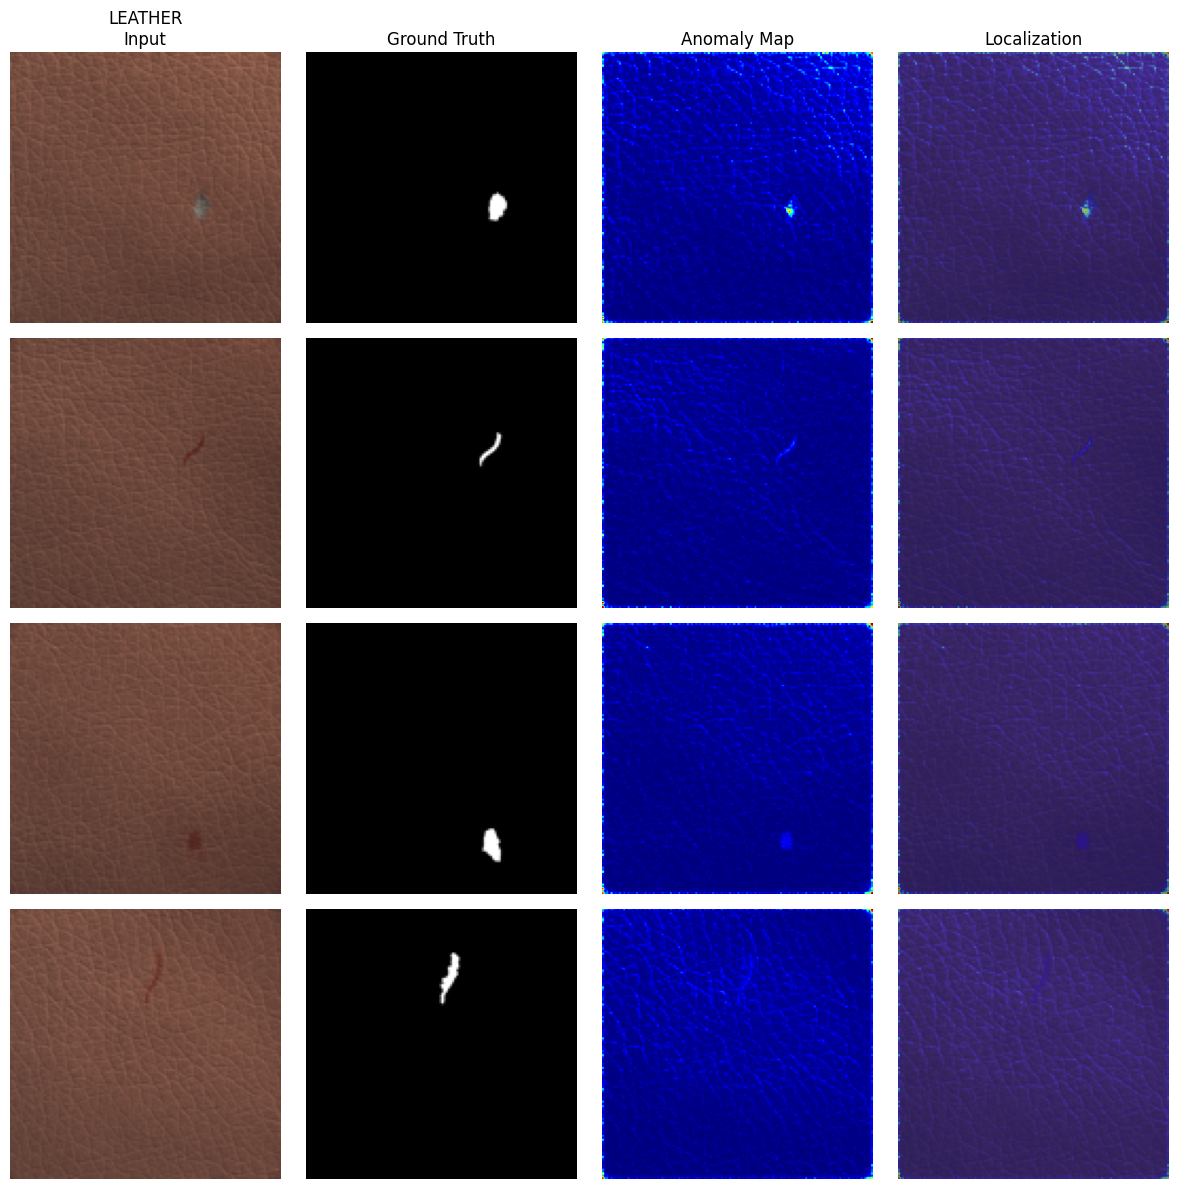


Training Class: metal_nut...

[EVALUATION: METAL_NUT] (Optimized Threshold: 0.087230)
AUROC: 0.4360 | Accuracy: 0.8000 | F1: 0.8889
Precision: 0.8070 | Recall: 0.9892 | Pixel-AUROC: 0.7903


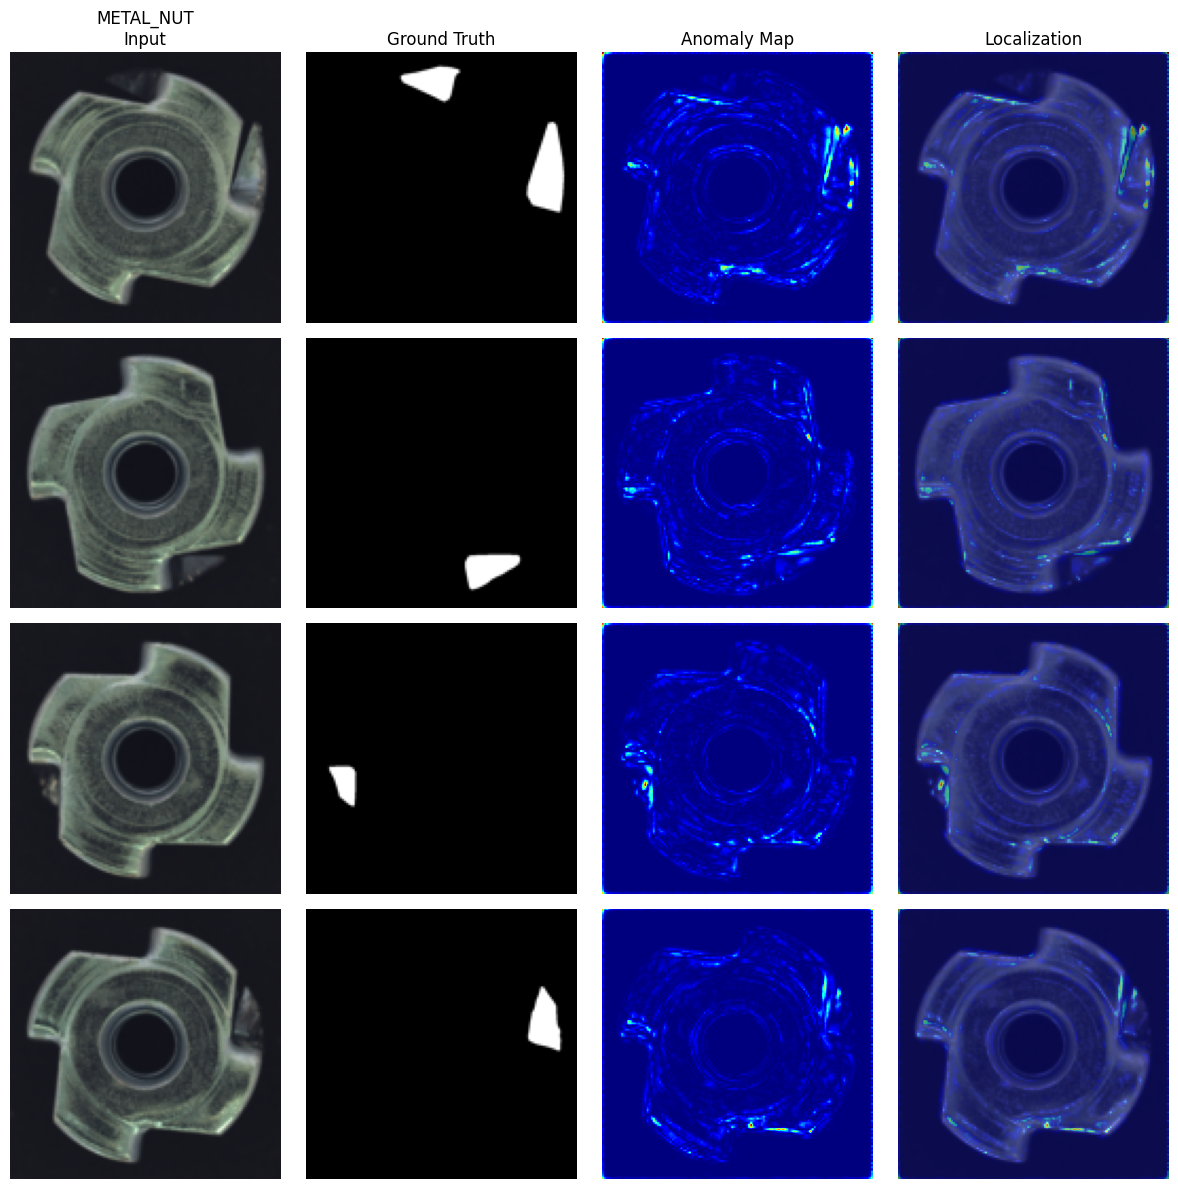


Training Class: zipper...

[EVALUATION: ZIPPER] (Optimized Threshold: 0.165808)
AUROC: 0.7340 | Accuracy: 0.8146 | F1: 0.8906
Precision: 0.8321 | Recall: 0.9580 | Pixel-AUROC: 0.7605


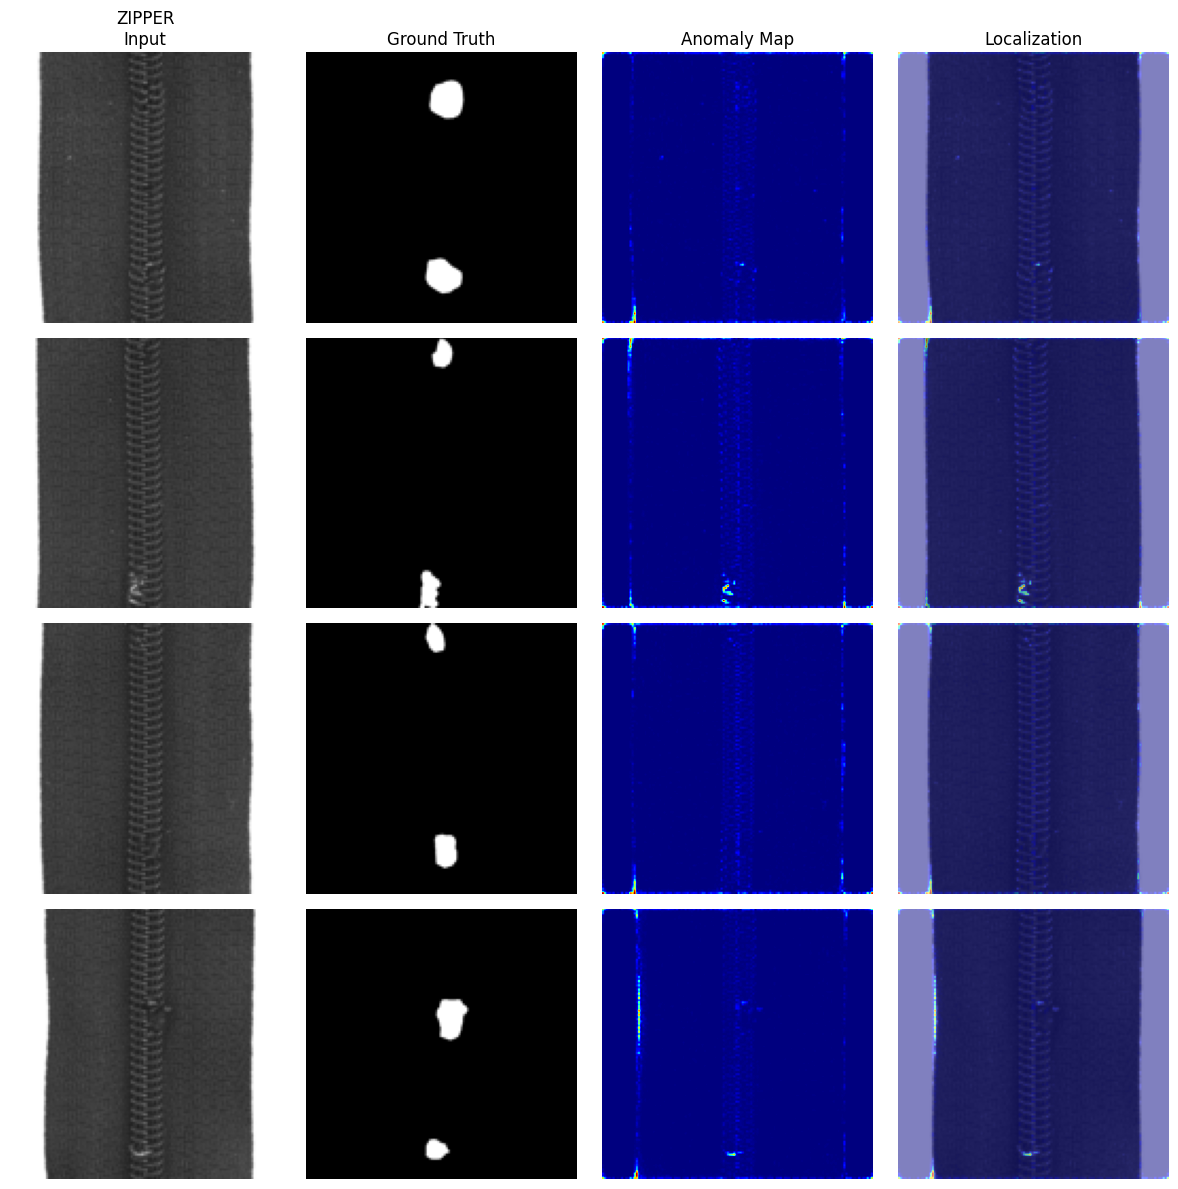


Training Class: bottle...

[EVALUATION: BOTTLE] (Optimized Threshold: 0.184438)
AUROC: 0.8944 | Accuracy: 0.8554 | F1: 0.8983
Precision: 0.9636 | Recall: 0.8413 | Pixel-AUROC: 0.8085


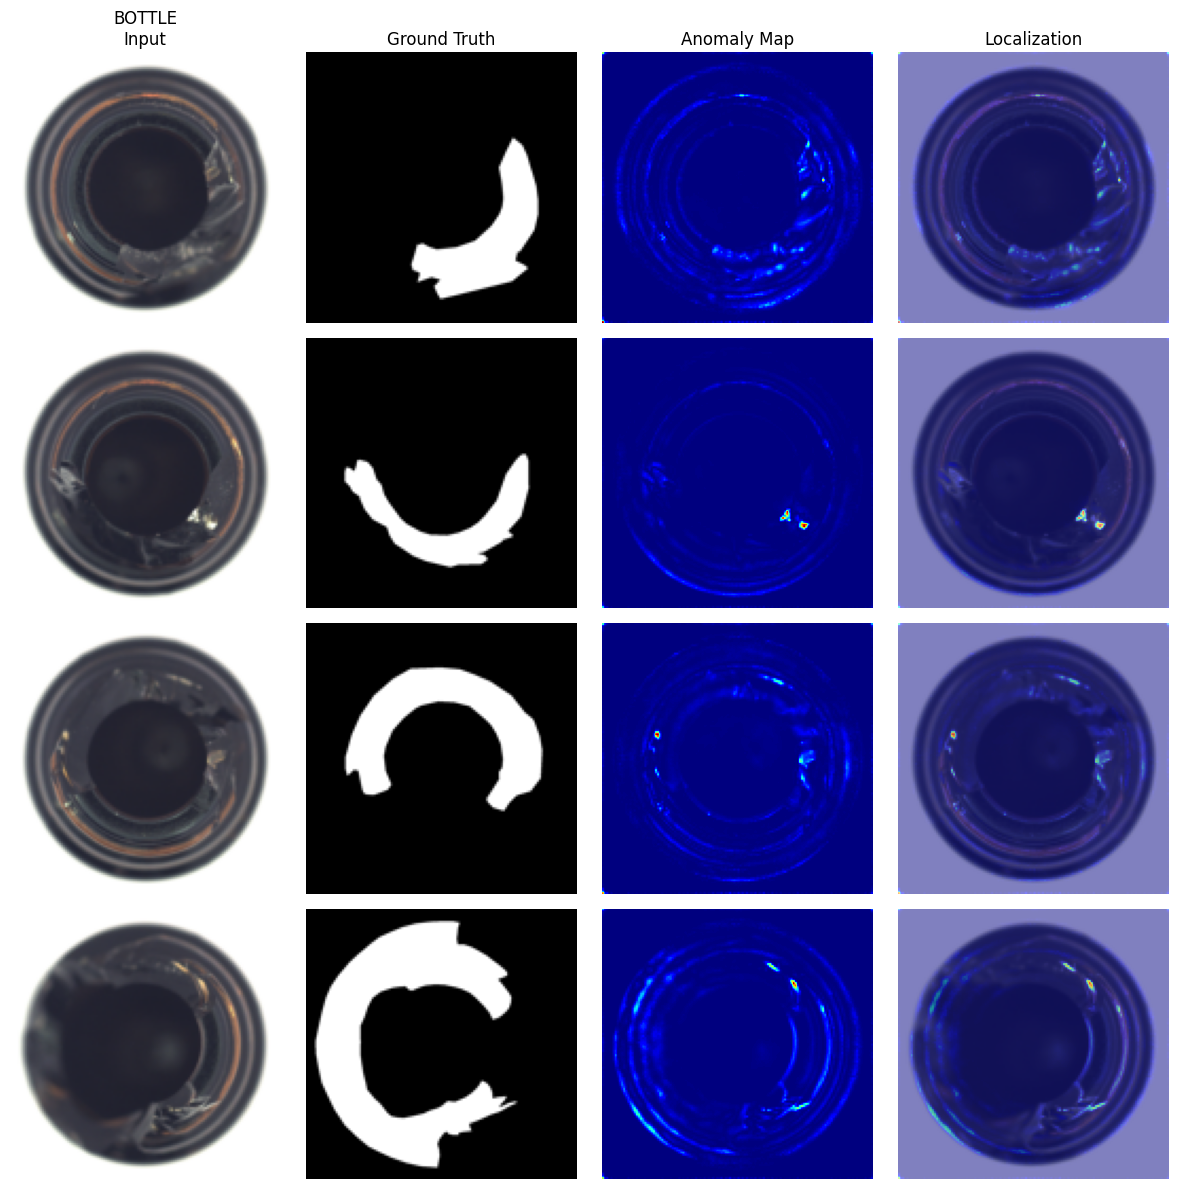

In [4]:
# --- 5. Execution Loop ---
transform = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor()])
results, summary_list = {}, []

for cls in CLASSES:
    print(f"\nTraining Class: {cls}...")
    train_loader = DataLoader(MVTecDataset(DATA_ROOT, cls, transform, 'train'), batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(MVTecDataset(DATA_ROOT, cls, transform, 'test'), batch_size=BATCH_SIZE, shuffle=False)
    
    model = Autoencoder().to(DEVICE)
    train_one_class(model, train_loader, NUM_EPOCHS)
    
    auroc, representative_sample = evaluate_and_visualize(model, test_loader, cls)
    results[cls] = auroc
    if representative_sample:
        representative_sample['name'] = cls
        summary_list.append(representative_sample)


FINAL SUMMARY VISUALIZATION


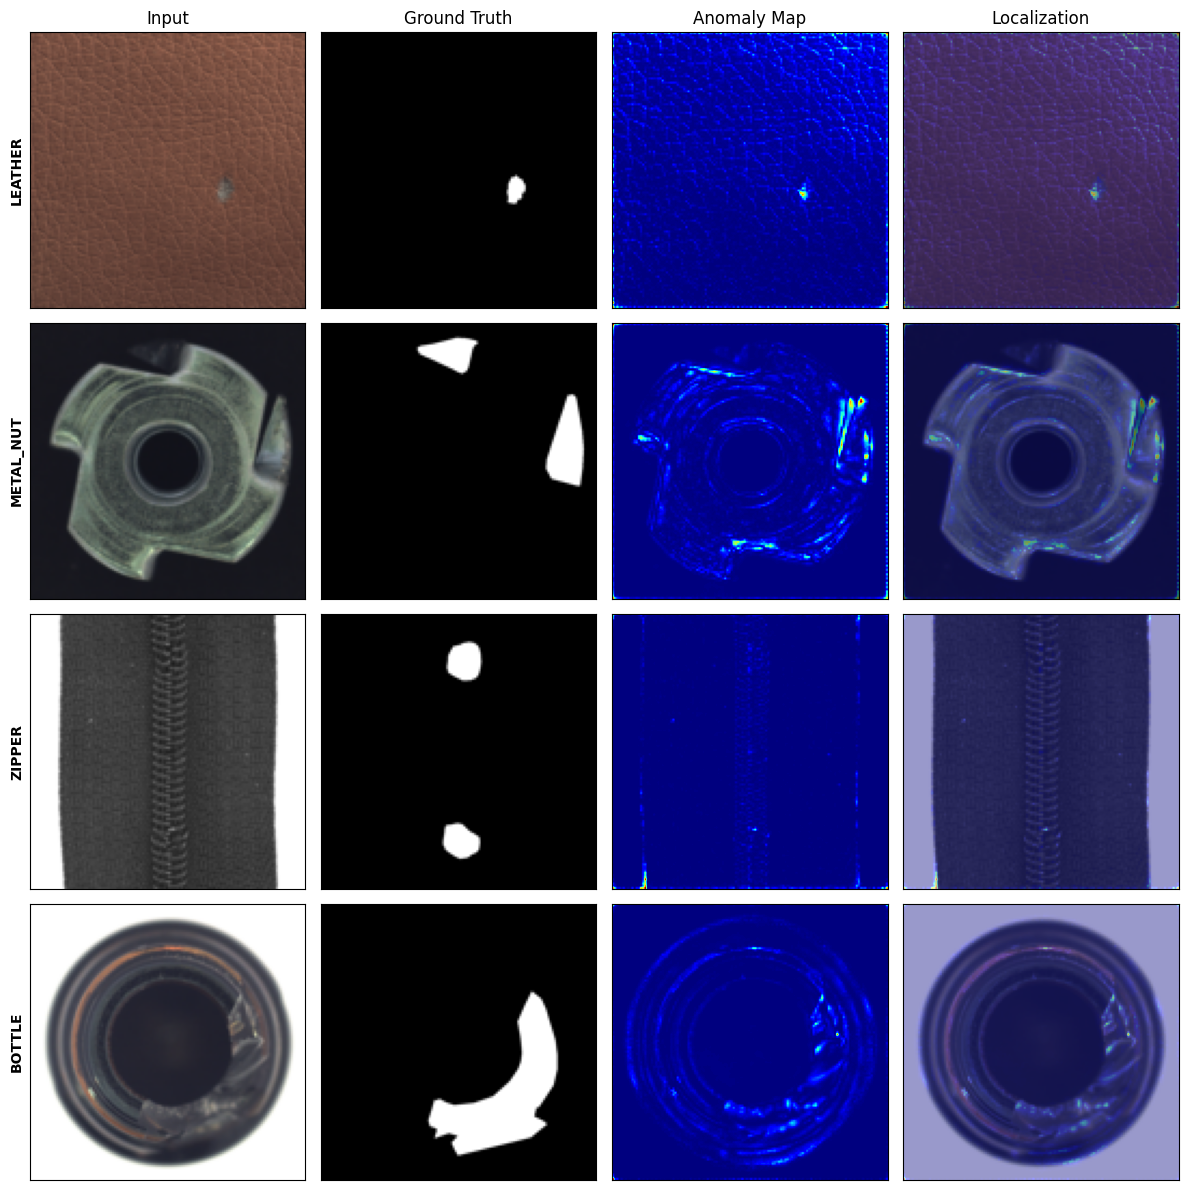


FINAL AUROC RESULTS
Leather        : 0.8713
Metal_nut      : 0.4360
Zipper         : 0.7340
Bottle         : 0.8944


In [5]:
# --- 6. Final Summary Visualization ---
if summary_list:
    print("\n" + "="*30 + "\nFINAL SUMMARY VISUALIZATION\n" + "="*30)
    fig, axes = plt.subplots(len(summary_list), 4, figsize=(12, 3 * len(summary_list)))
    for i, item in enumerate(summary_list):
        amap_norm = (item['amap'] - item['amap'].min()) / (item['amap'].max() - item['amap'].min() + 1e-8)
        axes[i, 0].imshow(item['img']); axes[i, 0].set_ylabel(item['name'].upper(), fontweight='bold')
        axes[i, 1].imshow(item['gt'], cmap='gray')
        axes[i, 2].imshow(amap_norm, cmap='jet')
        axes[i, 3].imshow(item['img']); axes[i, 3].imshow(amap_norm, cmap='jet', alpha=0.4)
        for j in range(4):
            axes[i, j].set_xticks([]); axes[i, j].set_yticks([])
            if i == 0: axes[i, j].set_title(['Input', 'Ground Truth', 'Anomaly Map', 'Localization'][j])
    plt.tight_layout(); plt.show()

print("\n" + "="*30 + "\nFINAL AUROC RESULTS\n" + "="*30)
for cls, score in results.items():
    print(f"{cls.capitalize():<15}: {score:.4f}")